### **ArkCheck** is a tool developed by **Ayman ElNashar** and **Georges Massabni** as part of the *Institute for Advanced Architecture of Catalonia Master in Advanced Computation for Architecture & Design* program for the **Academic Year 2023-2024 Final Thesis** supervised by faculty **João Silva**.

The tool explores application of Machine Learning Models, specifically an object detection CNN Deep learning model .(YOLOv5-YOLO5x-YOLOv8x) "You Only Look Once" and Vision Language Models (LLaVA-13B) "Large Language and Vision Assistant" which is a multi-modal machine learning model that combines language understanding and visual processing to identify, label, and analyze drafting errors in architectural drawings

# ArkCheck_V1.01

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset Prepration

Renaming all files and adding the image dimensions to the name

In [ ]:
import os
import cv2

def rename_files(image_dir, label_dir, start_idx=1, prefix="drawing"):
    # List all image files in the directory
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')])

    for idx, image_file in enumerate(image_files, start=start_idx):
        # Generate the new name based on the naming logic
        image_path = os.path.join(image_dir, image_file)

        # Read the image to get its dimensions
        image = cv2.imread(image_path)
        height, width, _ = image.shape
        dimensions = f"{width}x{height}"

        # Construct the new file name
        sequence_num = f"{idx:02}"  # Format sequence number as 01, 02, 03, etc.
        new_name = f"{prefix}_{sequence_num}_{dimensions}"

        # Paths for the new image and corresponding label files
        new_image_path = os.path.join(image_dir, f"{new_name}.jpg")
        old_label_path = os.path.join(label_dir, f"{os.path.splitext(image_file)[0]}.xml")
        new_label_path = os.path.join(label_dir, f"{new_name}.xml")

        # Rename the image and label files
        os.rename(image_path, new_image_path)
        if os.path.exists(old_label_path):
            os.rename(old_label_path, new_label_path)

        print(f"Renamed {image_file} and its label to {new_name}")

# Define the paths
dataset_dir = "/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset"
image_dir = os.path.join(dataset_dir, 'images')
label_dir = os.path.join(dataset_dir, 'labels')

# Rename files in the new dataset directory
rename_files(image_dir, label_dir)


Renamed Copy of BAGVL-BW-DAR-ZZ-EQC-00-PL-AR-00100 Layout1 (1).jpg and its label to drawing_01_3309x2339
Renamed Copy of BAGVL-BW-DAR-ZZ-JM1-00-PL-AR-00100 Layout1 (1).jpg and its label to drawing_02_2339x1654
Renamed Copy of BAGVL-BW-DAR-ZZ-JM1-XX-WS-AR-00400 Layout1 (1).jpg and its label to drawing_03_3309x2339
Renamed Copy of BAGVL-BW-DAR-ZZ-JM2-00-PL-AR-00100 Layout1 (1).jpg and its label to drawing_04_14042x9934
Renamed Copy of BAGVL-BW-DAR-ZZ-JM2-XX-DT-AR-00561 00561 (1).jpg and its label to drawing_05_14089x9934
Renamed Copy of BAGVL-BW-DAR-ZZ-WDH-00-PL-AR-00100 Layout1 (1).jpg and its label to drawing_06_14042x9934
Renamed Copy of BAGVL-BW-DAR-ZZ-WDH-XX-DT-AR-00570 Layout2 (1).jpg and its label to drawing_07_9362x6623
Renamed Copy of BAGVL-BW-DAR-ZZ-WDH-XX-SE-AR-00300 Layout1 (1).jpg and its label to drawing_08_14042x9934
Renamed Copy of BAGVL-BW-DAR-ZZ-WDH-XX-WS-AR-00402 Layout1 (1).jpg and its label to drawing_09_9362x6623
Renamed Copy of BAGVL-BW-DAR-ZZ-WDH-ZZ-AD-AR-00002 La

Splitting the Dataset to Train vs Validate - The script ensures that all classes are included in both sets

In [ ]:
import os
import random
import shutil
import xml.etree.ElementTree as ET

def extract_classes_from_xml(label_path):
    """Extracts the set of classes from an XML label file."""
    tree = ET.parse(label_path)
    root = tree.getroot()
    classes = set()
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        classes.add(class_name)
    return classes

def collect_class_instances(label_dir):
    """Collects label file paths by class."""
    class_instances = {}
    label_files = [f for f in os.listdir(label_dir) if f.endswith('.xml')]

    for label_file in label_files:
        label_path = os.path.join(label_dir, label_file)
        classes = extract_classes_from_xml(label_path)

        for class_name in classes:
            if class_name not in class_instances:
                class_instances[class_name] = []
            class_instances[class_name].append(label_file)

    return class_instances

def split_dataset_by_class(image_dir, label_dir, output_dir, split_ratio=0.7):
    # Create train and val directories with subdirectories for images and labels
    train_image_dir = os.path.join(output_dir, 'train', 'images')
    train_label_dir = os.path.join(output_dir, 'train', 'labels')
    val_image_dir = os.path.join(output_dir, 'val', 'images')
    val_label_dir = os.path.join(output_dir, 'val', 'labels')

    os.makedirs(train_image_dir, exist_ok=True)
    os.makedirs(train_label_dir, exist_ok=True)
    os.makedirs(val_image_dir, exist_ok=True)
    os.makedirs(val_label_dir, exist_ok=True)

    # Collect all label files by class
    class_instances = collect_class_instances(label_dir)

    train_files = set()
    val_files = set()

    for class_name, files in class_instances.items():
        random.shuffle(files)
        split_idx = int(len(files) * split_ratio)
        train_files.update(files[:split_idx])
        val_files.update(files[split_idx:])

    # Move the files
    def move_files(file_set, image_dir, label_dir, dest_image_dir, dest_label_dir):
        for label_file in file_set:
            image_file = label_file.replace('.xml', '.jpg')  # Assumes image extension is .jpg
            if not os.path.exists(os.path.join(image_dir, image_file)):
                continue

            shutil.copy(os.path.join(image_dir, image_file), os.path.join(dest_image_dir, image_file))
            shutil.copy(os.path.join(label_dir, label_file), os.path.join(dest_label_dir, label_file))

    move_files(train_files, image_dir, label_dir, train_image_dir, train_label_dir)
    move_files(val_files, image_dir, label_dir, val_image_dir, val_label_dir)

    print(f"Dataset split completed. Train: {len(train_files)} files, Val: {len(val_files)} files.")

# Define the paths
image_dir = "/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/images"
label_dir = "/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/labels"
output_dir = "/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/split"

# Split the dataset with a 70% train and 30% val ratio
split_dataset_by_class(image_dir, label_dir, output_dir, split_ratio=0.7)


Dataset split completed. Train: 27 files, Val: 16 files.


List all the labeling classes

In [ ]:
import os
import xml.etree.ElementTree as ET

def get_unique_classes_from_xml(xml_dir):
    unique_classes = set()

    # Loop through each XML file in the directory
    for xml_file in os.listdir(xml_dir):
        if xml_file.endswith('.xml'):
            # Parse the XML file
            tree = ET.parse(os.path.join(xml_dir, xml_file))
            root = tree.getroot()

            # Extract all class names in the XML file
            for obj in root.findall('object'):
                class_name = obj.find('name').text
                unique_classes.add(class_name)

    return unique_classes

# Directory containing your XML label files
xml_directory = '/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/labels'

# Get the list of unique classes
unique_classes = get_unique_classes_from_xml(xml_directory)

# Display the unique classes
print("Unique classes found in the XML files:", unique_classes)


Unique classes found in the XML files: {'OVERLAPPING_FURNITURE', 'OVERLAPPING_TAGS', 'OVERLAPPING_DIMENSIONS', 'OVERLAPPING_HATCH', 'MISSING_TAGS', 'DOOR_PLAN', 'OVERLAPPING_TEXT', 'overlapping_tags', 'Tag_error', 'missing_dwg_tag'}


Converting XML labels of different drawing sizes

In [ ]:
import os
import xml.etree.ElementTree as ET

# Define a mapping from class names to class IDs based on your unique classes
class_name_to_id = {
    'DOOR_PLAN': 0,
    'OVERLAPPING_HATCH': 1,
    'Tag_error': 2,
    'overlapping_tags': 3,
    'missing_dwg_tag': 4,
    'OVERLAPPING_TEXT': 5,
    'MISSING_TAGS': 6,
    'OVERLAPPING_DIMENSIONS': 7,
    'OVERLAPPING_TAGS': 8,
    'OVERLAPPING_FURNITURE': 9,
}

def convert_to_yolo_format(xml_file, txt_file, img_width, img_height):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    with open(txt_file, 'w') as f:
        for obj in root.findall('object'):
            label = obj.find('name').text
            if label in class_name_to_id:  # Ensure the label is in the class list
                xmlbox = obj.find('bndbox')
                x_min = int(xmlbox.find('xmin').text)
                y_min = int(xmlbox.find('ymin').text)
                x_max = int(xmlbox.find('xmax').text)
                y_max = int(xmlbox.find('ymax').text)

                # Normalize coordinates
                x_center = (x_min + x_max) / 2.0 / img_width
                y_center = (y_min + y_max) / 2.0 / img_height
                width = (x_max - x_min) / img_width
                height = (y_max - y_min) / img_height

                # YOLO format: <class_id> <x_center> <y_center> <width> <height>
                class_id = class_name_to_id[label]
                f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")
                print(f"Converted: {label} ({class_id}) {x_center} {y_center} {width} {height}")
            else:
                print(f"Warning: Unknown label {label} in {xml_file}")

# Helper function to extract image size from file name
def extract_image_size_from_name(file_name):
    dimensions = file_name.split('_')[-1].split('.')[0]  # Get dimensions part of the name
    try:
        width, height = map(int, dimensions.split('x'))
        return width, height
    except ValueError:
        raise ValueError(f"Could not extract image size from file name: {file_name}")

# Convert XML annotations to YOLO format for a given directory
def process_directory(label_dir):
    for xml_file in os.listdir(label_dir):
        if xml_file.endswith('.xml'):
            xml_path = os.path.join(label_dir, xml_file)
            txt_path = os.path.join(label_dir, os.path.splitext(xml_file)[0] + '.txt')

            # Extract image size from the naming convention
            try:
                img_width, img_height = extract_image_size_from_name(xml_file)
                print(f"Converting {xml_file} to {txt_path} with image size {img_width}x{img_height}")
                convert_to_yolo_format(xml_path, txt_path, img_width, img_height)
            except ValueError as e:
                print(f"Error processing {xml_file}: {e}")

# Define the paths
train_labels_dir = "/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/split/train/labels"
val_labels_dir = "/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/split/val/labels"

# Process train and val directories
process_directory(train_labels_dir)
process_directory(val_labels_dir)


Converting drawing_16_6623x4678.xml to /content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/split/train/labels/drawing_16_6623x4678.txt with image size 6623x4678
Converted: DOOR_PLAN (0) 0.34750113241733355 0.3271697306541257 0.03397252000603956 0.03954681487815306
Converted: DOOR_PLAN (0) 0.38668277215763247 0.2986318939717828 0.03563339876189038 0.043180846515604956
Converted: DOOR_PLAN (0) 0.4619507775932357 0.33026934587430523 0.036690321606522726 0.051303976058144504
Converted: DOOR_PLAN (0) 0.2324475313302129 0.30622060709705 0.02370526951532538 0.02672082086361693
Converted: DOOR_PLAN (0) 0.2556243394232221 0.30440359127832406 0.01660878755850823 0.036340316374519024
Converted: DOOR_PLAN (0) 0.12018722633247773 0.3417058572039333 0.01660878755850823 0.030141085934159897
Converted: DOOR_PLAN (0) 0.3062056469877699 0.3056861906797777 0.018722633247772912 0.03591278324070116
Converted: DOOR_PLAN (0) 0.5128340631133927 0.4070115433946131 0.035784387739695 0.0474561

Slicing both Images and Labels - The script doesnt move the label bounding box to avoid intersection with the tiles, Instead, it adjusts the tiles size to avoid intersection with the label bounding box

In [ ]:
import os
import cv2
import numpy as np

# Define the path for the sliced dataset
base_output_dir = '/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/sliced_dataset'

# Create output subfolders
output_train_img_dir = os.path.join(base_output_dir, 'train/images')
output_train_label_dir = os.path.join(base_output_dir, 'train/labels')
output_val_img_dir = os.path.join(base_output_dir, 'val/images')
output_val_label_dir = os.path.join(base_output_dir, 'val/labels')

# Create directories if they do not exist
os.makedirs(output_train_img_dir, exist_ok=True)
os.makedirs(output_train_label_dir, exist_ok=True)
os.makedirs(output_val_img_dir, exist_ok=True)
os.makedirs(output_val_label_dir, exist_ok=True)

def slice_image_and_label_adjust_tile(image_path, label_path, output_img_dir, output_label_dir, slice_size=1024):
    # Load image
    image = cv2.imread(image_path)
    img_height, img_width, _ = image.shape

    # Read the label file
    with open(label_path, 'r') as f:
        labels = f.readlines()

    slice_idx = 0
    y = 0
    while y < img_height:
        x = 0
        while x < img_width:
            # Start with the default tile size
            tile_width = slice_size
            tile_height = slice_size

            # Adjust the tile size based on the bounding boxes
            for label in labels:
                parts = label.strip().split()
                class_id = parts[0]
                x_center = float(parts[1]) * img_width
                y_center = float(parts[2]) * img_height
                width = float(parts[3]) * img_width
                height = float(parts[4]) * img_height

                # Calculate the bounding box coordinates
                box_x_min = x_center - width / 2.0
                box_y_min = y_center - height / 2.0
                box_x_max = x_center + width / 2.0
                box_y_max = y_center + height / 2.0

                # If the bounding box intersects with the current tile, expand the tile size
                if box_x_min < x + tile_width and box_x_max > x and box_y_min < y + tile_height and box_y_max > y:
                    tile_width = max(tile_width, int(box_x_max - x))
                    tile_height = max(tile_height, int(box_y_max - y))

            # Ensure the tile does not exceed image boundaries
            tile_width = min(tile_width, img_width - x)
            tile_height = min(tile_height, img_height - y)

            # Slice the image
            sliced_image = image[y:y+tile_height, x:x+tile_width]
            slice_filename = f"{os.path.splitext(os.path.basename(image_path))[0]}_{slice_idx:04d}.jpg"
            sliced_image_path = os.path.join(output_img_dir, slice_filename)
            cv2.imwrite(sliced_image_path, sliced_image)

            # Adjust the labels for the slice (only include labels that fully fit within the slice)
            sliced_labels = []
            for label in labels:
                parts = label.strip().split()
                class_id = parts[0]
                x_center = float(parts[1]) * img_width
                y_center = float(parts[2]) * img_height
                width = float(parts[3]) * img_width
                height = float(parts[4]) * img_height

                # Calculate the bounding box coordinates
                box_x_min = x_center - width / 2.0
                box_y_min = y_center - height / 2.0
                box_x_max = x_center + width / 2.0
                box_y_max = y_center + height / 2.0

                # Check if the bounding box is fully within the slice
                if box_x_min >= x and box_x_max <= x + tile_width and box_y_min >= y and box_y_max <= y + tile_height:
                    # Recalculate the normalized coordinates for the slice
                    new_x_center = (box_x_min + box_x_max) / 2.0 - x
                    new_y_center = (box_y_min + box_y_max) / 2.0 - y
                    new_x_center /= tile_width
                    new_y_center /= tile_height
                    new_width = width / tile_width
                    new_height = height / tile_height

                    sliced_labels.append(f"{class_id} {new_x_center} {new_y_center} {new_width} {new_height}\n")

            # Save the adjusted labels
            if sliced_labels:
                slice_label_filename = f"{os.path.splitext(os.path.basename(image_path))[0]}_{slice_idx:04d}.txt"
                sliced_label_path = os.path.join(output_label_dir, slice_label_filename)
                with open(sliced_label_path, 'w') as label_file:
                    label_file.writelines(sliced_labels)

            slice_idx += 1
            x += tile_width  # Move to the next slice horizontally
        y += tile_height  # Move to the next slice vertically

# Define the paths for the original dataset
train_image_dir = "/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/split/train/images"
val_image_dir = "/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/split/val/images"
train_label_dir = "/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/split/train/labels"
val_label_dir = "/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/split/val/labels"

# Process train images and labels
for image_file in os.listdir(train_image_dir):
    if image_file.endswith(('.jpg', '.png')):
        image_path = os.path.join(train_image_dir, image_file)
        label_path = os.path.join(train_label_dir, os.path.splitext(image_file)[0] + '.txt')
        slice_image_and_label_adjust_tile(image_path, label_path, output_train_img_dir, output_train_label_dir)

# Process val images and labels
for image_file in os.listdir(val_image_dir):
    if image_file.endswith(('.jpg', '.png')):
        image_path = os.path.join(val_image_dir, image_file)
        label_path = os.path.join(val_label_dir, os.path.splitext(image_file)[0] + '.txt')
        slice_image_and_label_adjust_tile(image_path, label_path, output_val_img_dir, output_val_label_dir)


Deleting sliced images that dont have corresponding labels

In [ ]:
import os

def delete_images_without_labels(image_dir, label_dir):
    # Get a list of all label files without the extension
    label_files = {os.path.splitext(label)[0] for label in os.listdir(label_dir) if label.endswith('.txt')}

    # Iterate over all image files in the directory
    for image_file in os.listdir(image_dir):
        image_path = os.path.join(image_dir, image_file)
        image_name_without_ext = os.path.splitext(image_file)[0]

        # Check if there is a corresponding label file
        if image_name_without_ext not in label_files:
            # If no corresponding label file, delete the image
            os.remove(image_path)
            print(f"Deleted image without label: {image_file}")

# Define the paths
output_train_img_dir = "/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/sliced_dataset/train/images"
output_train_label_dir = "/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/sliced_dataset/train/labels"
output_val_img_dir = "/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/sliced_dataset/val/images"
output_val_label_dir = "/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/sliced_dataset/val/labels"

# Delete images without labels in the train directory
delete_images_without_labels(output_train_img_dir, output_train_label_dir)

# Delete images without labels in the val directory
delete_images_without_labels(output_val_img_dir, output_val_label_dir)


Deleted image without label: drawing_16_6623x4678_0000.jpg
Deleted image without label: drawing_16_6623x4678_0001.jpg
Deleted image without label: drawing_16_6623x4678_0002.jpg
Deleted image without label: drawing_16_6623x4678_0003.jpg
Deleted image without label: drawing_16_6623x4678_0004.jpg
Deleted image without label: drawing_16_6623x4678_0005.jpg
Deleted image without label: drawing_16_6623x4678_0006.jpg
Deleted image without label: drawing_16_6623x4678_0011.jpg
Deleted image without label: drawing_16_6623x4678_0012.jpg
Deleted image without label: drawing_16_6623x4678_0013.jpg
Deleted image without label: drawing_16_6623x4678_0014.jpg
Deleted image without label: drawing_16_6623x4678_0015.jpg
Deleted image without label: drawing_16_6623x4678_0016.jpg
Deleted image without label: drawing_16_6623x4678_0017.jpg
Deleted image without label: drawing_16_6623x4678_0018.jpg
Deleted image without label: drawing_16_6623x4678_0019.jpg
Deleted image without label: drawing_16_6623x4678_0020.j

QA/QC - Veryfing label positioning after slicing

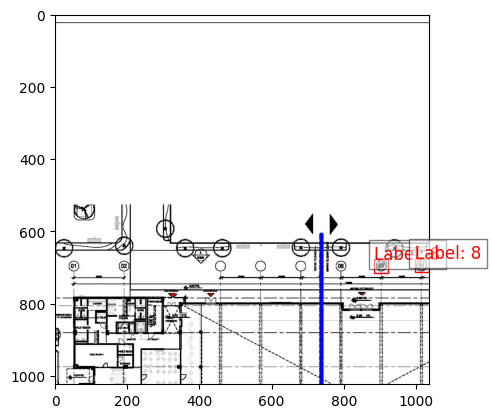

In [ ]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_annotations(image_path, label_path):
    image = cv2.imread(image_path)
    height, width, _ = image.shape

    fig, ax = plt.subplots(1)
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    with open(label_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            class_label = parts[0]  # Use string label instead of integer class ID
            x_center = float(parts[1]) * width
            y_center = float(parts[2]) * height
            bbox_width = float(parts[3]) * width
            bbox_height = float(parts[4]) * height

            x_min = x_center - (bbox_width / 2)
            y_min = y_center - (bbox_height / 2)

            rect = patches.Rectangle((x_min, y_min), bbox_width, bbox_height, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            plt.text(x_min, y_min, f"Label: {class_label}", color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.show()

# Adjusted Example usage with your paths
image_path = '/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/sliced_dataset/train/images/drawing_01_3309x2339_0001.jpg'
label_path = '/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/sliced_dataset/train/labels/drawing_01_3309x2339_0001.txt'

visualize_annotations(image_path, label_path)


## Training

Backup sliced Labels before merging

In [ ]:
labels_dirs = [
    '/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/sliced_dataset/train/labels',
    '/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/sliced_dataset/val/labels',
]


In [ ]:
import os
import shutil

for labels_dir in labels_dirs:
    backup_dir = labels_dir + '_backup'
    if not os.path.exists(backup_dir):
        shutil.copytree(labels_dir, backup_dir)
        print(f"Backup created at {backup_dir}")


Backup created at /content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/sliced_dataset/train/labels_backup
Backup created at /content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/sliced_dataset/val/labels_backup


Merging repeated/similar classes

In [ ]:
import os

# Mapping from old class IDs to new class IDs
id_mapping = {
    0: 0,  # DOOR_PLAN
    1: 1,  # OVERLAPPING_HATCH
    2: 2,  # Tag_error
    3: 6,  # 'overlapping_tags' -> 'OVERLAPPING_TAGS'
    4: 4,  # 'missing_dwg_tag' -> 'MISSING_TAGS'
    5: 3,  # OVERLAPPING_TEXT
    6: 4,  # 'MISSING_TAGS' remains with new ID
    7: 5,  # OVERLAPPING_DIMENSIONS
    8: 6,  # 'OVERLAPPING_TAGS' remains with new ID
    9: 7   # OVERLAPPING_FURNITURE
}

# Paths to your label directories
labels_dirs = [
    '/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/sliced_dataset/train/labels',
    '/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/sliced_dataset/val/labels',

]

# Update class IDs in label files
for labels_dir in labels_dirs:
    for root, dirs, files in os.walk(labels_dir):
        for filename in files:
            if filename.endswith('.txt'):
                file_path = os.path.join(root, filename)
                with open(file_path, 'r') as file:
                    lines = file.readlines()

                updated_lines = []
                for line in lines:
                    parts = line.strip().split()
                    if not parts:
                        continue  # Skip empty lines
                    old_class_id = int(parts[0])
                    if old_class_id in id_mapping:
                        new_class_id = id_mapping[old_class_id]
                        parts[0] = str(new_class_id)
                        updated_line = ' '.join(parts)
                        updated_lines.append(updated_line)
                    else:
                        print(f"Warning: Class ID {old_class_id} not in mapping for file {file_path}")
                        # Optionally handle unexpected class IDs here

                # Overwrite the file with updated lines
                with open(file_path, 'w') as file:
                    for updated_line in updated_lines:
                        file.write(f"{updated_line}\n")

Confirm classes are merged

In [ ]:
import os

# Valid class IDs
valid_class_ids = set(range(8))  # 0 to 7

labels_dirs = [
    '/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/sliced_dataset/train/labels',
    '/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/sliced_dataset/val/labels',

]

invalid_labels_found = False

for labels_dir in labels_dirs:
    for root, dirs, files in os.walk(labels_dir):
        for filename in files:
            if filename.endswith('.txt'):
                file_path = os.path.join(root, filename)
                with open(file_path, 'r') as file:
                    lines = file.readlines()

                for line_number, line in enumerate(lines, start=1):
                    parts = line.strip().split()
                    if not parts:
                        continue
                    class_id = int(parts[0])
                    if class_id not in valid_class_ids:
                        print(f"Invalid class ID {class_id} in file {file_path} on line {line_number}")
                        invalid_labels_found = True

if not invalid_labels_found:
    print("All labels have valid class IDs.")
else:
    print("Invalid class IDs found. Please update your labels accordingly.")


All labels have valid class IDs.


Setting up YOLO training .yaml file

In [ ]:
import os

# Define the content of the updated YAML file
yaml_content = """
train: /content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/sliced_dataset/train
val: /content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/sliced_dataset/val

nc: 8  # number of classes after merging
names: ['DOOR_PLAN', 'OVERLAPPING_HATCH', 'Tag_error', 'OVERLAPPING_TEXT', 'MISSING_TAGS',
        'OVERLAPPING_DIMENSIONS', 'OVERLAPPING_TAGS', 'OVERLAPPING_FURNITURE']
"""

# Write the content to a file
yaml_file_path = os.path.join("/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/sliced_dataset", 'custom_dataset02.yaml')
with open(yaml_file_path, 'w') as file:
    file.write(yaml_content)

print(f"YAML file created at {yaml_file_path}")


YAML file created at /content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/sliced_dataset/custom_dataset02.yaml


In [ ]:
# Install the necessary dependencies
!pip install matplotlib numpy opencv-python pillow PyYAML requests torch torchvision tqdm seaborn pandas scipy thop


In [ ]:
# Remove the existing folder if necessary and re-clone
!rm -rf yolov5
!git clone https://github.com/ultralytics/yolov5
%cd yolov5


Cloning into 'yolov5'...
remote: Enumerating objects: 16954, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 16954 (delta 76), reused 98 (delta 46), pack-reused 16805 (from 1)
Receiving objects: 100% (16954/16954), 15.70 MiB | 40.09 MiB/s, done.
Resolving deltas: 100% (11614/11614), done.
/content/yolov5


In [ ]:
# List the files to ensure 'requirements.txt' is present
!ls


benchmarks.py	 data	     LICENSE	     README.zh-CN.md   tutorial.ipynb
CITATION.cff	 detect.py   models	     requirements.txt  utils
classify	 export.py   pyproject.toml  segment	       val.py
CONTRIBUTING.md  hubconf.py  README.md	     train.py


In [ ]:
# Install the requirement (If the above cell returned and error)
!pip install -r requirements.txt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.6/871.6 kB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0


##YOLOv5

Fine tunining the hyperparameters

In [ ]:
# Define the content of the hyperparameter file
hyp_content = """
lr0: 0.005
lrf: 0.2
momentum: 0.95
weight_decay: 0.0005
warmup_epochs: 3.0
warmup_momentum: 0.8
warmup_bias_lr: 0.1
box: 0.05
cls: 1.0
cls_pw: 1.0
obj: 1.0
obj_pw: 1.0
iou_t: 0.3
anchor_t: 4.0
fl_gamma: 1.0
hsv_h: 0.015
hsv_s: 0.7
hsv_v: 0.4
degrees: 0.0
translate: 0.2
scale: 0.7
shear: 0.0
perspective: 0.0
flipud: 0.1
fliplr: 0.6
mosaic: 1.0
mixup: 0.0
copy_paste: 0.0
"""

# Write the content to a file
hyp_file_path = '/content/yolov5/data/hyps/hyp.finetune_4th.yaml'
with open(hyp_file_path, 'w') as file:
    file.write(hyp_content)

print(f"Hyperparameter file created at {hyp_file_path}")


Hyperparameter file created at /content/yolov5/data/hyps/hyp.finetune_4th.yaml


Adjusting the training parameters to handle the various sliced sizes approach (Rectangular method)

In [ ]:
!python /content/yolov5/train.py --img 1024 --batch 16 --epochs 500 --data /content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/sliced_dataset/custom_dataset02.yaml --weights yolov5s.pt --cache --hyp /content/yolov5/data/hyps/hyp.finetune_4th.yaml --patience 50 --rect


Streaming output truncated to the last 5000 lines.
    328/499      12.2G    0.01853   0.002236   0.001044         26       1024:  17% 2/12 [00:00<00:01,  8.18it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
    328/499      12.2G    0.01918   0.002382   0.001043         41       1024:  25% 3/12 [00:00<00:01,  7.56it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
    328/499      12.2G    0.01742   0.002126  0.0009052         19       1024:  33% 4/12 [00:00<00:01,  6.99it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
    328/499      12.2G     0.0179   0.00

In [ ]:
# Define the source and destination paths
source_path = '/content/yolov5/runs/train/exp/weights/best.pt'
destination_path = '/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/sliced_dataset/best_model_4errors_4thtrail_v5.pt'

# Copy the best model to the desired location
!cp {source_path} {destination_path}

print(f"Best model saved to {destination_path}")


Best model saved to /content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/sliced_dataset/best_model_4errors_4thtrail_v5.pt


In [ ]:
# Copy training plots
!cp -r /content/yolov5/runs/train/exp /content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/YOLOv5_Training_Plots

##YoloV5x

In [ ]:
# Ensure you're in the yolov5 directory
%cd /content/yolov5/

# Train the model using YOLOv5x with early stopping
!python train.py \
  --img 640 \
  --batch 8 \
  --epochs 500 \
  --data '/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/sliced_dataset/custom_dataset02.yaml' \
  --weights yolov5x.pt \
  --patience 50  # Early stop if no improvement after 50 validation epochs


Streaming output truncated to the last 5000 lines.
    402/499      9.31G    0.01443   0.006915  0.0007203         24        640:  30% 7/23 [00:00<00:02,  7.30it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
    402/499      9.31G    0.01498   0.007274  0.0007177         42        640:  35% 8/23 [00:01<00:02,  7.42it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
    402/499      9.31G    0.01441   0.006935  0.0006985         17        640:  39% 9/23 [00:01<00:01,  7.48it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
    402/499      9.31G    0.01374   0.00

In [ ]:
# Define the source and destination paths
source_path = '/content/yolov5/runs/train/exp5/weights/best.pt'
destination_path = '/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/sliced_dataset/best_model_4errors_4thtrail_v5X.pt'

# Copy the best model to the desired location
!cp {source_path} {destination_path}

print(f"Best model saved to {destination_path}")


Best model saved to /content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/sliced_dataset/best_model_4errors_4thtrail_v5X.pt


In [ ]:
# Copy training plots
!cp -r /content/yolov5/runs/train/exp5 /content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/YOLOv5x_Training_plots

##YOLOv8x

In [ ]:
# Install YOLOv8
!pip install ultralytics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.9/871.9 kB 47.7 MB/s eta 0:00:00


In [ ]:
import ultralytics
ultralytics.checks()


Ultralytics YOLOv8.2.92 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 34.0/235.7 GB disk)


In [ ]:
from ultralytics import YOLO

# Load the YOLOv8 model (v8x for larger version, v8s for smaller)
model = YOLO('yolov8x.pt')

# Train the model
model.train(data='/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/sliced_dataset/custom_dataset02.yaml',
            epochs=500,
            batch=8,
            imgsz=640,
            patience=50)  # Early stopping with patience


100%|██████████| 131M/131M [00:00<00:00, 493MB/s] 


New https://pypi.org/project/ultralytics/8.2.93 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.92 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/sliced_dataset/custom_dataset02.yaml, epochs=500, time=None, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment

100%|██████████| 6.25M/6.25M [00:00<00:00, 421MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/sliced_dataset/train/labels... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:01<00:00, 176.23it/s]

train: New cache created: /content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/sliced_dataset/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/sliced_dataset/val/labels... 133 images, 0 backgrounds, 0 corrupt: 100%|██████████| 133/133 [00:00<00:00, 137.98it/s]


val: New cache created: /content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/sliced_dataset/val/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 500 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/500      9.55G      1.842      5.863      1.586          0        640: 100%|██████████| 23/23 [00:04<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  5.30it/s]

                   all        133        274      0.514     0.0967     0.0495     0.0293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/500      7.62G      1.848      4.477      1.662          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  5.62it/s]

                   all        133        274       0.16       0.14     0.0114    0.00511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/500      7.36G      1.743      3.513      1.653          2        640: 100%|██████████| 23/23 [00:03<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.61it/s]

                   all        133        274    0.00483      0.038    0.00246    0.00126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/500      7.57G      1.798      3.516      1.756          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.71it/s]

                   all        133        274   0.000873     0.0718   0.000576   0.000365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/500      7.59G      1.946        4.7      1.791          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.85it/s]


                   all        133        274      0.158     0.0475    0.00192     0.0013

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/500      7.32G      1.963      3.428      1.891          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.65it/s]

                   all        133        274     0.0293       0.05    0.00762    0.00417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/500      7.61G        1.9      3.286      1.919          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.33it/s]


                   all        133        274      0.588    0.00939    0.00558    0.00158

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/500       7.6G      1.859      3.019      1.883          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  5.94it/s]

                   all        133        274     0.0678      0.185     0.0132    0.00469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/500      7.63G      1.867      2.872      1.823          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.44it/s]

                   all        133        274      0.573      0.182      0.119     0.0604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/500      7.59G      1.721      2.506      1.778          8        640: 100%|██████████| 23/23 [00:03<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.33it/s]

                   all        133        274       0.49       0.13      0.131     0.0651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/500      7.61G      1.807      2.474      1.712          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.25it/s]


                   all        133        274      0.406      0.118       0.13     0.0527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/500      7.58G      1.722      2.342       1.78          8        640: 100%|██████████| 23/23 [00:03<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.27it/s]

                   all        133        274      0.406      0.118       0.13     0.0527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/500      7.61G      1.599      2.096      1.578          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all        133        274      0.039      0.134     0.0265    0.00826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/500      7.32G      1.576      2.255      1.683          0        640: 100%|██████████| 23/23 [00:03<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.28it/s]

                   all        133        274    0.00415     0.0376    0.00743    0.00319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/500      7.58G      1.622      2.237      1.683          7        640: 100%|██████████| 23/23 [00:03<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.73it/s]

                   all        133        274      0.414     0.0577     0.0442     0.0144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/500      7.59G      1.632      2.126       1.64          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.21it/s]

                   all        133        274      0.411       0.25      0.162     0.0846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/500      7.63G      1.588      2.111      1.628          1        640: 100%|██████████| 23/23 [00:03<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.10it/s]

                   all        133        274      0.413      0.221      0.219      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/500       7.6G      1.432      1.923      1.569          3        640: 100%|██████████| 23/23 [00:03<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.96it/s]


                   all        133        274      0.452      0.326      0.231      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/500      7.59G      1.605      1.994       1.64          1        640: 100%|██████████| 23/23 [00:03<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.38it/s]


                   all        133        274      0.389       0.17      0.155     0.0876

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/500      7.55G      1.543      1.905      1.678          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.42it/s]

                   all        133        274      0.315      0.129     0.0929      0.055



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/500       7.6G      1.489      1.756      1.589          7        640: 100%|██████████| 23/23 [00:03<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.76it/s]

                   all        133        274       0.84      0.181      0.221        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/500      7.36G      1.523      1.784      1.528          4        640: 100%|██████████| 23/23 [00:03<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.53it/s]

                   all        133        274      0.428      0.496      0.385      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/500      7.59G      1.491      1.929       1.51          4        640: 100%|██████████| 23/23 [00:03<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.51it/s]


                   all        133        274      0.513      0.385      0.349      0.155

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/500       7.6G       1.46      1.844      1.549          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.64it/s]


                   all        133        274      0.563      0.465      0.458      0.242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/500      7.57G      1.405      1.741      1.442          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.54it/s]


                   all        133        274      0.549      0.507      0.468      0.253

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/500      7.57G      1.448       1.71      1.487          5        640: 100%|██████████| 23/23 [00:03<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.42it/s]


                   all        133        274       0.61      0.476      0.445      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/500       7.6G      1.352      1.534      1.491          4        640: 100%|██████████| 23/23 [00:03<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.97it/s]


                   all        133        274      0.656      0.485       0.53      0.283

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/500      7.57G      1.394      1.595      1.449          0        640: 100%|██████████| 23/23 [00:03<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.95it/s]

                   all        133        274      0.528      0.565      0.504      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/500      7.59G      1.358      1.477      1.452          5        640: 100%|██████████| 23/23 [00:03<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.44it/s]


                   all        133        274      0.627      0.449      0.486      0.277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/500      7.33G      1.415      1.549      1.549          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.24it/s]

                   all        133        274       0.74      0.381      0.455      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/500      7.62G      1.461      1.532      1.571          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.53it/s]

                   all        133        274      0.609      0.469      0.479      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/500      7.59G      1.419       1.91      1.525          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.68it/s]

                   all        133        274        0.8      0.307      0.493      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/500      7.59G      1.393      1.549      1.429          6        640: 100%|██████████| 23/23 [00:03<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.28it/s]


                   all        133        274      0.636      0.616      0.543      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/500      7.59G        1.4      1.506      1.437          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.26it/s]


                   all        133        274      0.689      0.503      0.543      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/500       7.6G      1.317      1.411      1.396          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.13it/s]


                   all        133        274      0.602      0.578      0.539      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/500      7.57G      1.367      1.457      1.425          5        640: 100%|██████████| 23/23 [00:03<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.34it/s]


                   all        133        274      0.737      0.504      0.558      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/500      7.63G      1.315      1.473      1.395          6        640: 100%|██████████| 23/23 [00:03<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.44it/s]

                   all        133        274      0.735      0.415      0.508      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/500      7.36G      1.295      1.385      1.392          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.23it/s]

                   all        133        274      0.654       0.54      0.523      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/500      7.61G      1.345      1.428      1.403          6        640: 100%|██████████| 23/23 [00:03<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.46it/s]


                   all        133        274      0.666      0.205      0.294      0.149

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/500       7.6G      1.323      1.452       1.45          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.73it/s]

                   all        133        274      0.649      0.253      0.278       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/500       7.6G      1.363      1.425      1.476          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.54it/s]

                   all        133        274      0.547      0.503        0.5      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/500       7.6G      1.384      1.358      1.424          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.60it/s]

                   all        133        274      0.645      0.518      0.508      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/500       7.6G      1.313      1.435      1.472          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.25it/s]


                   all        133        274      0.644       0.57      0.562      0.296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/500       7.6G      1.273      1.398        1.4          5        640: 100%|██████████| 23/23 [00:03<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.34it/s]


                   all        133        274      0.686      0.635      0.627      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/500      7.61G      1.265      1.238        1.4          4        640: 100%|██████████| 23/23 [00:03<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.82it/s]

                   all        133        274      0.688      0.579      0.591      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/500      7.33G      1.239      1.284      1.398          5        640: 100%|██████████| 23/23 [00:03<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.23it/s]


                   all        133        274      0.674      0.604      0.582      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/500      7.59G       1.23      1.273      1.352          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.74it/s]


                   all        133        274      0.721       0.57      0.585      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/500       7.6G      1.324      1.333      1.462          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.71it/s]

                   all        133        274      0.748      0.579      0.615      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/500      7.61G      1.342      1.324      1.416          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.01it/s]

                   all        133        274      0.727      0.623      0.627       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/500       7.6G      1.305      1.241      1.352          6        640: 100%|██████████| 23/23 [00:03<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.50it/s]


                   all        133        274      0.685      0.526      0.559      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/500       7.6G      1.239      1.204       1.36         11        640: 100%|██████████| 23/23 [00:03<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.47it/s]


                   all        133        274      0.365      0.592      0.542      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/500      7.61G      1.275      1.191      1.352          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.20it/s]


                   all        133        274      0.695      0.599       0.65      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/500      7.59G      1.318      1.352      1.473          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.60it/s]

                   all        133        274       0.73      0.571      0.615      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/500      7.32G      1.233      1.269      1.372          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.13it/s]


                   all        133        274      0.598      0.618      0.616      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/500       7.6G      1.218      1.136      1.322          6        640: 100%|██████████| 23/23 [00:03<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.68it/s]

                   all        133        274      0.823      0.596       0.63      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/500      7.59G      1.196      1.195      1.327          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.67it/s]

                   all        133        274      0.783      0.509      0.583       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/500       7.6G      1.327      1.178      1.381          7        640: 100%|██████████| 23/23 [00:03<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.67it/s]

                   all        133        274      0.622      0.556      0.549      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/500       7.6G       1.13      1.116      1.344          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.53it/s]


                   all        133        274       0.73      0.571      0.603      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/500      7.57G      1.159      1.066      1.291          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.48it/s]


                   all        133        274      0.768      0.594      0.615      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/500       7.6G      1.202      1.151      1.285          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.14it/s]

                   all        133        274      0.784      0.613       0.66      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/500      7.59G      1.158      1.095      1.353          7        640: 100%|██████████| 23/23 [00:03<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.75it/s]

                   all        133        274      0.702      0.538      0.583      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/500      7.33G      1.163       1.15      1.271          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.40it/s]


                   all        133        274      0.472      0.375      0.319      0.148

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/500      7.61G      1.171      1.068       1.31          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.79it/s]

                   all        133        274      0.761      0.528      0.583      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/500       7.6G      1.231      1.169      1.324          7        640: 100%|██████████| 23/23 [00:03<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.61it/s]

                   all        133        274      0.757      0.581      0.601       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/500      7.61G      1.146      1.021      1.292          6        640: 100%|██████████| 23/23 [00:03<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.36it/s]

                   all        133        274      0.715      0.662      0.638       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/500      7.62G      1.184      1.087      1.353          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.96it/s]

                   all        133        274      0.833      0.618      0.691      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/500      7.59G      1.156       1.06      1.285          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.51it/s]


                   all        133        274      0.768      0.622      0.676      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/500       7.6G      1.096      1.036      1.313          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.45it/s]

                   all        133        274      0.749      0.583      0.635      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/500       7.6G      1.217       1.14      1.333          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.56it/s]

                   all        133        274      0.772      0.608       0.63      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/500      7.33G      1.156      1.022      1.258          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.37it/s]

                   all        133        274       0.79      0.576      0.624      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/500      7.62G      1.253       1.15      1.332          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.37it/s]


                   all        133        274      0.813      0.565      0.606      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/500       7.6G      1.156     0.9755      1.233          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.56it/s]

                   all        133        274      0.612      0.632      0.637      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/500       7.6G      1.249      1.186      1.363          4        640: 100%|██████████| 23/23 [00:03<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.23it/s]

                   all        133        274      0.613      0.649      0.651      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/500      7.62G      1.123     0.9914      1.298          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.58it/s]

                   all        133        274      0.743      0.656      0.678      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/500      7.59G       1.16      1.077      1.296          1        640: 100%|██████████| 23/23 [00:03<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.65it/s]

                   all        133        274      0.821      0.641      0.704      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/500      7.57G       1.27      1.128      1.371          1        640: 100%|██████████| 23/23 [00:03<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.51it/s]

                   all        133        274      0.813      0.546      0.658      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/500      7.63G      1.184      1.133      1.293          8        640: 100%|██████████| 23/23 [00:03<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.68it/s]

                   all        133        274      0.731       0.62      0.673       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/500      7.33G      1.163      1.043       1.26          5        640: 100%|██████████| 23/23 [00:03<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.35it/s]


                   all        133        274      0.761      0.657      0.677      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/500       7.6G      1.126      1.009      1.268          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.40it/s]

                   all        133        274      0.816      0.628      0.694      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/500      7.57G      1.117     0.9797      1.265          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.45it/s]

                   all        133        274      0.841      0.619      0.688      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/500       7.6G       1.11      1.205      1.239          0        640: 100%|██████████| 23/23 [00:03<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.04it/s]

                   all        133        274      0.782      0.649      0.678      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/500      7.62G      1.122       1.03      1.288          5        640: 100%|██████████| 23/23 [00:03<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.86it/s]

                   all        133        274      0.706      0.667      0.681      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/500      7.57G      1.139      1.001      1.275          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.41it/s]

                   all        133        274      0.824      0.617      0.682      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/500      7.55G      1.198      1.127      1.322          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.59it/s]

                   all        133        274      0.709      0.619      0.673       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/500      7.59G      1.125      1.051      1.314          5        640: 100%|██████████| 23/23 [00:03<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.57it/s]

                   all        133        274      0.897       0.63       0.68      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/500      7.33G      1.269      1.238      1.385          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.28it/s]

                   all        133        274      0.866      0.609      0.676      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/500       7.6G      1.092     0.9441      1.293          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.42it/s]


                   all        133        274      0.844      0.605      0.682      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/500      7.58G      1.143     0.9324      1.292          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.61it/s]

                   all        133        274      0.852      0.626      0.701      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/500       7.6G      1.057     0.8867      1.229          5        640: 100%|██████████| 23/23 [00:03<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.61it/s]

                   all        133        274      0.906      0.607      0.697      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/500      7.61G      1.074     0.9764      1.271          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.37it/s]


                   all        133        274      0.865      0.637      0.708      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/500      7.59G      1.081       0.94      1.226          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.56it/s]

                   all        133        274      0.883      0.662      0.727       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/500      7.57G      1.073     0.9641      1.312          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.42it/s]


                   all        133        274      0.872      0.711       0.74      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/500       7.6G      1.058     0.8693      1.242          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.56it/s]


                   all        133        274      0.895      0.649      0.737      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/500      7.36G      1.093      1.027      1.276          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.11it/s]

                   all        133        274      0.864       0.63      0.729       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/500      7.61G      1.013     0.9199      1.199          0        640: 100%|██████████| 23/23 [00:03<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.58it/s]

                   all        133        274      0.883      0.585      0.656      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/500      7.63G      1.064      1.031      1.236          5        640: 100%|██████████| 23/23 [00:03<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.49it/s]


                   all        133        274      0.811      0.649      0.659       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/500      7.63G      1.099      1.034      1.284          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.20it/s]

                   all        133        274      0.895      0.644      0.721      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/500       7.6G      1.051      1.023       1.26          5        640: 100%|██████████| 23/23 [00:03<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.64it/s]

                   all        133        274      0.865      0.635      0.696      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/500      7.59G     0.9742     0.8899      1.177          0        640: 100%|██████████| 23/23 [00:03<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.61it/s]


                   all        133        274      0.817      0.656       0.71      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/500      7.57G      1.014     0.8888        1.2          2        640: 100%|██████████| 23/23 [00:03<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  7.96it/s]

                   all        133        274      0.733      0.618      0.706       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/500      7.61G      1.046     0.8823       1.22         10        640: 100%|██████████| 23/23 [00:03<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.58it/s]

                   all        133        274       0.91      0.627      0.698      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/500      7.34G      1.083       0.95      1.241          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.65it/s]

                   all        133        274      0.826      0.659      0.703      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/500      7.59G      1.034     0.8849      1.225          0        640: 100%|██████████| 23/23 [00:03<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.23it/s]

                   all        133        274      0.876      0.622      0.685      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/500       7.6G      1.064     0.9091      1.255          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.45it/s]

                   all        133        274       0.73      0.609      0.646      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/500      7.61G      1.069     0.8179      1.219          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.38it/s]

                   all        133        274      0.806      0.652      0.691      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/500      7.59G      1.097     0.9444      1.273          4        640: 100%|██████████| 23/23 [00:03<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.28it/s]

                   all        133        274       0.82      0.653      0.696       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/500      7.63G      1.042     0.8807      1.259          7        640: 100%|██████████| 23/23 [00:03<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.60it/s]


                   all        133        274      0.829      0.634        0.7      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/500      7.57G      1.037     0.8511      1.219          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.23it/s]

                   all        133        274      0.802      0.666      0.701      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/500       7.6G     0.9958      0.771      1.199          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.74it/s]

                   all        133        274      0.897      0.598      0.706      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/500       7.3G      1.042     0.8515      1.244          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.76it/s]

                   all        133        274      0.876      0.633      0.702      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/500      7.59G      1.035     0.8309      1.197          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.56it/s]


                   all        133        274      0.867      0.645      0.722      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/500      7.62G      1.007     0.8263      1.224          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.93it/s]

                   all        133        274      0.822      0.573      0.669      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/500       7.6G      1.038      0.848      1.236          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.57it/s]

                   all        133        274      0.812      0.672      0.689      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/500      7.63G      1.095     0.9025      1.209          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.62it/s]


                   all        133        274      0.759      0.651      0.729      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/500       7.6G      1.011     0.7784      1.165          5        640: 100%|██████████| 23/23 [00:03<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.37it/s]

                   all        133        274      0.896      0.607      0.719      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/500      7.61G      1.016     0.8466      1.213          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.78it/s]

                   all        133        274      0.894      0.673      0.716       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/500      7.59G     0.8797     0.9025      1.128          0        640: 100%|██████████| 23/23 [00:03<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.59it/s]

                   all        133        274      0.843      0.564      0.635      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/500      7.34G       1.01     0.8743      1.205          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.56it/s]

                   all        133        274      0.855      0.659      0.681      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/500      7.63G     0.9635     0.8477      1.192          4        640: 100%|██████████| 23/23 [00:03<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.43it/s]


                   all        133        274      0.852      0.641      0.697      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/500      7.61G      0.998     0.9065      1.234          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.65it/s]

                   all        133        274       0.88      0.692      0.721      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/500      7.61G      0.952     0.7989      1.131          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.51it/s]


                   all        133        274      0.893      0.686      0.725      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/500       7.6G      1.092     0.9552      1.243          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.26it/s]

                   all        133        274      0.858      0.659      0.724      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/500      7.59G      1.045     0.8371      1.243          4        640: 100%|██████████| 23/23 [00:03<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.67it/s]

                   all        133        274      0.818      0.623      0.699      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/500      7.55G      1.006     0.8395      1.202          9        640: 100%|██████████| 23/23 [00:03<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.36it/s]

                   all        133        274      0.845      0.622      0.688      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/500      7.61G     0.9622       1.21      1.118          0        640: 100%|██████████| 23/23 [00:03<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.57it/s]

                   all        133        274       0.85      0.693      0.729       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/500      7.32G      0.949     0.7657      1.143          4        640: 100%|██████████| 23/23 [00:03<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.55it/s]

                   all        133        274       0.92      0.665      0.735      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/500       7.6G     0.9235     0.7577      1.155          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.66it/s]

                   all        133        274       0.83      0.698      0.719      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/500      7.58G      1.053     0.8571      1.217          6        640: 100%|██████████| 23/23 [00:03<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.36it/s]

                   all        133        274      0.879      0.689      0.735      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/500      7.62G     0.9856     0.8408      1.158          0        640: 100%|██████████| 23/23 [00:03<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.78it/s]

                   all        133        274      0.876       0.67      0.743      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/500       7.6G      0.953     0.7375      1.176          4        640: 100%|██████████| 23/23 [00:03<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.19it/s]

                   all        133        274      0.861      0.689      0.743       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/500      7.59G     0.9916     0.7454      1.186          6        640: 100%|██████████| 23/23 [00:03<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.19it/s]

                   all        133        274       0.87      0.672      0.742       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/500      7.54G     0.9805     0.7508      1.155          5        640: 100%|██████████| 23/23 [00:03<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.96it/s]

                   all        133        274      0.906      0.624      0.723       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/500       7.6G      1.056     0.7921      1.227          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.19it/s]

                   all        133        274      0.836      0.638      0.679      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/500      7.34G      0.919     0.7462      1.184          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.38it/s]

                   all        133        274      0.812      0.621      0.664      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/500       7.6G     0.9048     0.7372       1.12          0        640: 100%|██████████| 23/23 [00:03<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.43it/s]


                   all        133        274      0.872      0.611       0.69      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/500      7.63G     0.8728     0.6502      1.138          4        640: 100%|██████████| 23/23 [00:03<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.49it/s]


                   all        133        274      0.883      0.637      0.693      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/500      7.59G      1.002     0.7828      1.188          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.67it/s]

                   all        133        274      0.897      0.661      0.712      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/500      7.59G     0.9164     0.6843      1.123          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.42it/s]

                   all        133        274      0.915      0.651      0.733      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/500      7.59G     0.9687     0.6972      1.149          5        640: 100%|██████████| 23/23 [00:03<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.52it/s]

                   all        133        274      0.939      0.641      0.731      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/500      7.57G     0.9542     0.7634      1.187          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.88it/s]

                   all        133        274      0.878      0.628      0.725      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/500      7.61G     0.9394     0.8853      1.155          0        640: 100%|██████████| 23/23 [00:03<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.06it/s]

                   all        133        274      0.914      0.631      0.714      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/500      7.35G     0.8471     0.8553      1.126          0        640: 100%|██████████| 23/23 [00:03<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.69it/s]

                   all        133        274      0.883      0.657      0.716      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/500      7.57G      1.022     0.7818       1.18          4        640: 100%|██████████| 23/23 [00:03<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.42it/s]


                   all        133        274      0.863      0.638      0.698       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/500       7.6G     0.9608     0.7179      1.224          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.38it/s]

                   all        133        274      0.893      0.617      0.708      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/500       7.6G     0.9353     0.7567       1.19          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.60it/s]

                   all        133        274      0.901      0.654      0.721      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/500      7.62G     0.9304     0.7147      1.185          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.64it/s]

                   all        133        274      0.874      0.646      0.732       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/500      7.59G      1.019     0.7983      1.246          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.53it/s]


                   all        133        274      0.856      0.656      0.726      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/500      7.57G     0.8726     0.6724      1.104          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.60it/s]

                   all        133        274      0.889      0.678      0.729        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/500       7.6G     0.8893     0.6946      1.184          2        640: 100%|██████████| 23/23 [00:03<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.49it/s]

                   all        133        274      0.911      0.682      0.729      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/500      7.36G     0.9044     0.7256      1.149          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.24it/s]

                   all        133        274      0.873      0.652      0.724      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/500      7.61G      0.906     0.7173      1.153          5        640: 100%|██████████| 23/23 [00:03<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.60it/s]

                   all        133        274       0.91      0.641      0.727      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/500      7.57G     0.9212     0.7251      1.177          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.55it/s]


                   all        133        274      0.877      0.692       0.73      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/500       7.6G     0.9657      0.793      1.155         13        640: 100%|██████████| 23/23 [00:03<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.65it/s]


                   all        133        274      0.829      0.667      0.704      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/500      7.59G     0.9728      0.755        1.2          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.68it/s]

                   all        133        274      0.865      0.693      0.742      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/500      7.61G     0.9631      0.752      1.182         12        640: 100%|██████████| 23/23 [00:03<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.55it/s]

                   all        133        274      0.889      0.717      0.752      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/500      7.57G     0.8753     0.7208      1.144          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.67it/s]

                   all        133        274      0.918      0.677      0.733      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/500      7.61G     0.9386     0.8004      1.172          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.63it/s]

                   all        133        274      0.891      0.646      0.707      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/500       7.3G     0.9126     0.7771      1.155          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.32it/s]

                   all        133        274      0.881      0.662      0.704      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/500       7.6G      0.904     0.7219      1.162          4        640: 100%|██████████| 23/23 [00:03<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.59it/s]

                   all        133        274      0.881      0.662      0.714      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/500      7.57G     0.9035     0.6573      1.147          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.64it/s]


                   all        133        274      0.886      0.666      0.725      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/500      7.63G     0.8498     0.6939      1.079          0        640: 100%|██████████| 23/23 [00:03<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.27it/s]

                   all        133        274      0.859       0.71       0.74      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/500       7.6G     0.8654     0.6691      1.148          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.63it/s]


                   all        133        274      0.873      0.708      0.745      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/500      7.59G     0.8966     0.7874      1.133          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.34it/s]

                   all        133        274      0.918      0.702      0.746      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/500      7.57G     0.8852     0.7225      1.137          5        640: 100%|██████████| 23/23 [00:03<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.62it/s]

                   all        133        274      0.892      0.701      0.746        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/500      7.61G     0.8301     0.6839        1.1          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.85it/s]

                   all        133        274       0.88      0.691      0.739      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/500      7.33G      0.842     0.7078      1.139          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.27it/s]

                   all        133        274      0.846      0.689      0.735      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/500      7.59G     0.8876      0.714      1.123          4        640: 100%|██████████| 23/23 [00:03<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.23it/s]


                   all        133        274      0.862      0.688      0.734      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/500       7.6G     0.8977      0.746      1.112          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.58it/s]

                   all        133        274      0.864      0.665       0.72      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/500       7.6G       0.85     0.6462      1.139          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.58it/s]

                   all        133        274      0.835      0.684      0.725      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/500      7.59G     0.8398      0.686      1.121          6        640: 100%|██████████| 23/23 [00:03<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.66it/s]

                   all        133        274      0.849      0.726       0.75      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/500      7.59G     0.8367     0.7116      1.131          5        640: 100%|██████████| 23/23 [00:03<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.35it/s]

                   all        133        274      0.882      0.709      0.756      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/500      7.58G     0.8848     0.7149      1.137          4        640: 100%|██████████| 23/23 [00:03<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.37it/s]


                   all        133        274      0.865       0.69      0.742       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/500      7.62G     0.8019     0.6524       1.06          0        640: 100%|██████████| 23/23 [00:03<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.79it/s]

                   all        133        274      0.945      0.657      0.758      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/500      7.33G     0.8413      0.672      1.131          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.46it/s]


                   all        133        274       0.91      0.674      0.756      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/500      7.59G      0.879     0.6944      1.131          7        640: 100%|██████████| 23/23 [00:03<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.53it/s]

                   all        133        274      0.929      0.653      0.756      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/500      7.61G     0.8777     0.6782      1.136          7        640: 100%|██████████| 23/23 [00:03<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.26it/s]

                   all        133        274      0.912      0.685      0.738      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/500      7.59G     0.7955     0.6498       1.09          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.48it/s]


                   all        133        274       0.88      0.673       0.72        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/500      7.57G     0.8026     0.6524      1.125          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.68it/s]

                   all        133        274      0.893       0.65      0.703      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/500       7.6G      0.826     0.6492      1.086          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.71it/s]

                   all        133        274      0.905      0.664      0.725      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/500      7.58G     0.8163     0.8322      1.108          0        640: 100%|██████████| 23/23 [00:03<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.27it/s]


                   all        133        274      0.906      0.641      0.731      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/500      7.57G     0.8488     0.6239      1.081          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.63it/s]

                   all        133        274      0.884      0.634      0.712      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/500      7.34G     0.8692     0.6992      1.182          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.61it/s]

                   all        133        274      0.861      0.629      0.692      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/500      7.59G     0.8361     0.6412      1.104          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.56it/s]


                   all        133        274      0.942      0.606      0.684      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/500       7.6G     0.9278     0.7074      1.137          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.76it/s]

                   all        133        274      0.871      0.652       0.71      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/500      7.61G     0.8653     0.6892      1.125          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.54it/s]


                   all        133        274      0.892       0.67      0.734      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/500       7.6G     0.8342     0.6127      1.093          5        640: 100%|██████████| 23/23 [00:03<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.67it/s]

                   all        133        274      0.905      0.661      0.736      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/500      7.63G     0.8239      0.686      1.127          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.56it/s]

                   all        133        274      0.886      0.694      0.725      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/500      7.61G     0.8375     0.6214      1.147          5        640: 100%|██████████| 23/23 [00:03<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.19it/s]


                   all        133        274      0.894      0.677      0.722      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/500      7.57G     0.8024     0.6512      1.076          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.50it/s]

                   all        133        274      0.884      0.671      0.725      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/500       7.3G     0.8484     0.5813      1.102          7        640: 100%|██████████| 23/23 [00:03<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.65it/s]

                   all        133        274      0.874      0.635       0.71      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/500      7.63G     0.9148     0.6921      1.164          5        640: 100%|██████████| 23/23 [00:03<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.24it/s]


                   all        133        274      0.833      0.609      0.677      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/500      7.63G     0.8532     0.6646      1.119          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.63it/s]

                   all        133        274      0.895       0.62      0.723      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/500       7.6G     0.7907     0.6839      1.096          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.46it/s]


                   all        133        274      0.884      0.684      0.745      0.536

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/500      7.61G     0.8087      0.592      1.125          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.45it/s]


                   all        133        274       0.95      0.662      0.741      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/500      7.59G      0.809     0.6513      1.139          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.88it/s]

                   all        133        274      0.917      0.672      0.733      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/500       7.6G     0.9035     0.7061      1.173          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.60it/s]

                   all        133        274      0.889      0.663      0.726       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/500       7.6G     0.7707     0.5935      1.031          0        640: 100%|██████████| 23/23 [00:03<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.41it/s]

                   all        133        274      0.881      0.638      0.714      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/500      7.31G     0.8267     0.6498      1.129          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.59it/s]

                   all        133        274      0.929      0.619      0.712      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/500       7.6G     0.7549     0.5952      1.051          0        640: 100%|██████████| 23/23 [00:03<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.53it/s]

                   all        133        274       0.87      0.681      0.724      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/500      7.63G     0.7463     0.5571      1.054          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.51it/s]

                   all        133        274      0.896      0.669      0.729      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/500      7.59G     0.7917     0.6789      1.101          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.91it/s]

                   all        133        274      0.888      0.681      0.734      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/500      7.63G     0.7882     0.8449      1.064          0        640: 100%|██████████| 23/23 [00:03<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.44it/s]

                   all        133        274      0.873      0.683      0.732      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/500      7.58G     0.8343     0.6449      1.123          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.50it/s]


                   all        133        274      0.926       0.67      0.724      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/500      7.55G     0.7612     0.5679      1.055          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.56it/s]

                   all        133        274      0.905      0.675      0.724       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/500      7.59G     0.7957     0.6267      1.097          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.49it/s]

                   all        133        274       0.93      0.666      0.713      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/500      7.33G     0.7926     0.6012        1.1          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.50it/s]

                   all        133        274      0.925      0.654      0.707      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/500       7.6G     0.8011     0.6327      1.089          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.60it/s]

                   all        133        274      0.918      0.647      0.707      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/500       7.6G     0.7883      0.611      1.091          4        640: 100%|██████████| 23/23 [00:03<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.25it/s]

                   all        133        274      0.905      0.639      0.724      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/500       7.6G     0.7783     0.5547       1.06          8        640: 100%|██████████| 23/23 [00:03<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.77it/s]

                   all        133        274      0.965      0.642      0.731       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/500       7.6G      0.829     0.7611      1.119          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.48it/s]

                   all        133        274      0.912      0.659      0.715       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/500      7.59G     0.7763     0.6203      1.098          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.63it/s]


                   all        133        274       0.92      0.649      0.703      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/500      7.58G     0.7717      0.565      1.081          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.83it/s]

                   all        133        274      0.898      0.669      0.705      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/500      7.59G     0.7538     0.5532      1.104          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.30it/s]

                   all        133        274       0.91      0.656      0.706      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/500      7.33G     0.7459     0.5982      1.036          6        640: 100%|██████████| 23/23 [00:03<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.71it/s]

                   all        133        274      0.928       0.65      0.707      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/500      7.59G     0.8046      0.608      1.065          6        640: 100%|██████████| 23/23 [00:03<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.70it/s]

                   all        133        274      0.962      0.629      0.717      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/500       7.6G     0.7884     0.5817      1.072          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.38it/s]


                   all        133        274      0.946      0.647      0.741      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/500      7.61G     0.7467     0.5435       1.04          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.60it/s]

                   all        133        274      0.942      0.664      0.744      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/500      7.59G     0.7155     0.5596      1.044          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.71it/s]

                   all        133        274      0.916      0.695      0.747      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/500      7.57G     0.7147     0.5289      1.077          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.19it/s]


                   all        133        274      0.889      0.716      0.757      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/500      7.55G     0.7564     0.5505      1.072          5        640: 100%|██████████| 23/23 [00:03<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.68it/s]

                   all        133        274      0.893      0.678      0.743       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/500      7.58G     0.6945     0.5194      1.008          0        640: 100%|██████████| 23/23 [00:03<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.45it/s]

                   all        133        274      0.951      0.623      0.734      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/500      7.33G     0.7629     0.5779      1.085          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.68it/s]

                   all        133        274      0.933      0.654      0.726      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/500       7.6G     0.7767     0.5443      1.061          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.39it/s]


                   all        133        274      0.927      0.641      0.712       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/500       7.6G     0.7345     0.5645      1.033          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.49it/s]

                   all        133        274      0.935      0.647      0.711      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/500      7.57G     0.8004     0.5955       1.07          5        640: 100%|██████████| 23/23 [00:03<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.80it/s]

                   all        133        274       0.95      0.652      0.734       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/500      7.59G     0.8082      0.608      1.058          5        640: 100%|██████████| 23/23 [00:03<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.61it/s]

                   all        133        274      0.796      0.664      0.744      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/500      7.59G     0.8524     0.8155      1.118          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.38it/s]

                   all        133        274      0.772      0.668      0.743      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/500      7.55G     0.7642     0.5458      1.075          6        640: 100%|██████████| 23/23 [00:03<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.64it/s]

                   all        133        274      0.772      0.699      0.762      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/500      7.59G     0.6887     0.5697      1.044          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.68it/s]

                   all        133        274      0.777      0.695      0.767      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/500      7.36G     0.7326     0.5893      1.039          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.43it/s]

                   all        133        274       0.75      0.707      0.755      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/500      7.59G     0.6994     0.5166      1.068          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.68it/s]

                   all        133        274      0.918      0.667      0.753      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/500       7.6G     0.7657     0.5738      1.081          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.55it/s]


                   all        133        274      0.943      0.659      0.742       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/500      7.61G     0.8036     0.6233      1.073          4        640: 100%|██████████| 23/23 [00:03<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.02it/s]

                   all        133        274      0.927      0.674      0.736      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/500      7.62G     0.7655      0.578      1.035          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.65it/s]

                   all        133        274      0.937       0.65      0.733      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/500      7.59G     0.7935     0.6178      1.101          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.32it/s]


                   all        133        274       0.89      0.693      0.746      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/500      7.56G     0.7369      0.585      1.008          0        640: 100%|██████████| 23/23 [00:03<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.73it/s]

                   all        133        274       0.91      0.681      0.749      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/500      7.59G     0.7524     0.5562      1.087          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.45it/s]

                   all        133        274      0.927      0.652      0.735      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/500      7.31G     0.7295     0.5339       1.05          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.26it/s]


                   all        133        274      0.919      0.665      0.734      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/500      7.62G     0.7068     0.5505      1.024          4        640: 100%|██████████| 23/23 [00:03<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.52it/s]

                   all        133        274      0.921      0.682      0.746      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/500      7.57G     0.7483     0.5795      1.045          5        640: 100%|██████████| 23/23 [00:03<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.51it/s]


                   all        133        274      0.914      0.694       0.74      0.538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/500       7.6G     0.7345      0.559      1.041          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.52it/s]

                   all        133        274      0.905      0.674      0.731      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/500       7.6G     0.7672     0.5423      1.119          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.66it/s]

                   all        133        274      0.921      0.682      0.727      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/500       7.6G     0.6958     0.5231      1.051          4        640: 100%|██████████| 23/23 [00:03<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.58it/s]

                   all        133        274      0.932      0.682      0.744      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/500      7.57G     0.7417     0.5309      1.072          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.44it/s]

                   all        133        274      0.924      0.701      0.748      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/500       7.6G     0.7292     0.5402      1.064          6        640: 100%|██████████| 23/23 [00:03<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.78it/s]

                   all        133        274      0.917      0.702      0.753      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/500      7.33G     0.7639      0.603      1.085          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.13it/s]


                   all        133        274      0.921      0.687      0.746      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/500       7.6G     0.7934     0.5976      1.089          8        640: 100%|██████████| 23/23 [00:03<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.39it/s]

                   all        133        274      0.936      0.679       0.75       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/500      7.63G     0.7327     0.5396      1.039          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.63it/s]

                   all        133        274       0.94      0.678      0.751       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/500       7.6G     0.7667      0.789      1.065          1        640: 100%|██████████| 23/23 [00:03<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.20it/s]

                   all        133        274      0.945      0.675      0.752      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/500      7.59G     0.7769     0.5893      1.112          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.65it/s]

                   all        133        274      0.919      0.664      0.734      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/500       7.6G      0.844      0.638      1.073          4        640: 100%|██████████| 23/23 [00:03<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.30it/s]

                   all        133        274      0.899      0.676      0.731      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/500      7.55G     0.7104     0.5186       1.01          4        640: 100%|██████████| 23/23 [00:03<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.46it/s]

                   all        133        274      0.931      0.677      0.743      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/500       7.6G       0.75     0.5294       1.04          4        640: 100%|██████████| 23/23 [00:03<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.57it/s]


                   all        133        274      0.785      0.694      0.756      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/500      7.36G     0.7246     0.5474      1.047         11        640: 100%|██████████| 23/23 [00:03<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.34it/s]


                   all        133        274      0.789      0.699      0.752      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/500      7.57G       0.71     0.5336      1.072          5        640: 100%|██████████| 23/23 [00:03<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.38it/s]


                   all        133        274      0.789        0.7      0.751      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/500      7.63G     0.6851     0.4728     0.9956          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.58it/s]

                   all        133        274      0.893       0.72      0.748      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/500      7.59G     0.7294     0.5409      1.071          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.17it/s]


                   all        133        274      0.905      0.687      0.748      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/500      7.62G     0.6377      0.507      1.001          0        640: 100%|██████████| 23/23 [00:03<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.72it/s]

                   all        133        274      0.899      0.694      0.741      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/500      7.62G     0.6883     0.5318      1.025          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.55it/s]

                   all        133        274      0.938      0.675      0.738      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/500      7.57G     0.7211     0.5415      1.035          4        640: 100%|██████████| 23/23 [00:03<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.42it/s]


                   all        133        274      0.935      0.677      0.738      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/500       7.6G     0.6981     0.4868     0.9995          7        640: 100%|██████████| 23/23 [00:03<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.66it/s]

                   all        133        274      0.926      0.697      0.741      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/500       7.3G     0.6862     0.5265      1.006          5        640: 100%|██████████| 23/23 [00:03<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.66it/s]

                   all        133        274      0.905      0.719      0.741      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/500      7.61G     0.7799     0.5661      1.116          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.61it/s]

                   all        133        274      0.919      0.723      0.751      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/500      7.63G     0.7373     0.5897      1.062          4        640: 100%|██████████| 23/23 [00:03<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.36it/s]

                   all        133        274      0.928      0.712      0.758      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/500      7.59G     0.6985     0.5286      1.031          3        640: 100%|██████████| 23/23 [00:03<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.38it/s]


                   all        133        274      0.952      0.702       0.77      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/500       7.6G     0.7071     0.5396      1.037          2        640: 100%|██████████| 23/23 [00:03<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.59it/s]

                   all        133        274       0.93       0.72      0.779      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    267/500      7.59G       0.74     0.5341      1.054          9        640: 100%|██████████| 23/23 [00:03<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.55it/s]


                   all        133        274      0.923      0.688      0.772      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    268/500      7.57G     0.6851      0.555      1.033          2        640: 100%|██████████| 23/23 [00:03<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.65it/s]

                   all        133        274      0.899      0.685      0.754      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/500       7.6G     0.7315     0.5382      1.008          6        640: 100%|██████████| 23/23 [00:03<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.45it/s]

                   all        133        274      0.888      0.688      0.745      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    270/500      7.35G     0.6976     0.5222      1.062          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.56it/s]

                   all        133        274      0.926      0.678      0.744      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    271/500       7.6G     0.6795     0.5244      1.077          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.39it/s]


                   all        133        274      0.959      0.669      0.748      0.565

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    272/500       7.6G     0.7387     0.6028       1.04          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.48it/s]

                   all        133        274      0.928      0.676      0.753      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    273/500       7.6G     0.6898     0.5199     0.9902          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.57it/s]


                   all        133        274      0.885      0.712      0.747       0.56

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    274/500      7.61G      0.638     0.4887     0.9974          9        640: 100%|██████████| 23/23 [00:03<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.55it/s]

                   all        133        274      0.896      0.728      0.747      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    275/500      7.61G     0.7204     0.5602      1.079          5        640: 100%|██████████| 23/23 [00:03<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.72it/s]

                   all        133        274      0.765      0.692      0.735       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    276/500      7.58G     0.6911     0.5477      1.028          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.38it/s]

                   all        133        274      0.903      0.681      0.718      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    277/500      7.59G     0.6661     0.5355      1.024          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.84it/s]

                   all        133        274      0.761       0.68       0.72      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    278/500      7.33G     0.7296     0.5575      1.059          7        640: 100%|██████████| 23/23 [00:03<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.61it/s]

                   all        133        274      0.901      0.681      0.727      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    279/500      7.63G     0.6308     0.4869     0.9871          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.53it/s]


                   all        133        274      0.891      0.702      0.753      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    280/500       7.6G     0.6535     0.5028      1.002          0        640: 100%|██████████| 23/23 [00:03<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.43it/s]

                   all        133        274      0.927      0.708      0.756      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    281/500       7.6G     0.6734     0.5128      1.023          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.24it/s]

                   all        133        274      0.924      0.702      0.751      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    282/500       7.6G     0.6177     0.5029     0.9509          0        640: 100%|██████████| 23/23 [00:03<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.30it/s]

                   all        133        274      0.927       0.69      0.739      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    283/500      7.63G     0.8153     0.5593      1.029          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.54it/s]

                   all        133        274      0.922      0.661      0.726      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    284/500      7.57G     0.6623     0.5158      1.008          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.79it/s]

                   all        133        274      0.941      0.665      0.727      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    285/500       7.6G     0.7007     0.5512      1.041          6        640: 100%|██████████| 23/23 [00:03<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.53it/s]

                   all        133        274       0.95      0.676      0.739       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    286/500      7.33G     0.6726     0.5083      1.028          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.37it/s]

                   all        133        274        0.9      0.695       0.75      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    287/500       7.6G     0.6284     0.4975     0.9682          0        640: 100%|██████████| 23/23 [00:03<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.39it/s]

                   all        133        274      0.935      0.684      0.753       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    288/500       7.6G     0.6613     0.4841      1.017          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.56it/s]

                   all        133        274      0.925      0.689      0.752      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    289/500      7.63G      0.677     0.5003      1.029          5        640: 100%|██████████| 23/23 [00:03<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.67it/s]


                   all        133        274      0.926      0.673      0.743      0.556

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    290/500       7.6G     0.6446     0.4977      1.023          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.37it/s]

                   all        133        274      0.926      0.663      0.749      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    291/500       7.6G     0.6723     0.4995      1.034          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.80it/s]

                   all        133        274      0.934      0.657      0.751      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    292/500      7.59G     0.6575     0.5122     0.9994          9        640: 100%|██████████| 23/23 [00:03<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.63it/s]

                   all        133        274      0.887       0.69      0.754      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    293/500      7.59G     0.6323     0.4569      1.004          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.59it/s]


                   all        133        274      0.888      0.682      0.751      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    294/500      7.34G     0.6726     0.4978      1.041          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.84it/s]

                   all        133        274      0.934      0.671      0.749      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    295/500      7.61G     0.6208     0.4689     0.9969          4        640: 100%|██████████| 23/23 [00:03<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.46it/s]

                   all        133        274      0.935       0.68      0.744      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    296/500      7.59G     0.6025     0.4551     0.9355          0        640: 100%|██████████| 23/23 [00:03<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.41it/s]


                   all        133        274      0.941       0.68      0.742       0.56

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    297/500      7.63G     0.6514     0.5847      1.037          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.62it/s]

                   all        133        274       0.95      0.678      0.746      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    298/500      7.59G     0.6517     0.4791     0.9832          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.57it/s]

                   all        133        274      0.936      0.677      0.742      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    299/500       7.6G     0.6524     0.9264      0.946          0        640: 100%|██████████| 23/23 [00:03<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.35it/s]

                   all        133        274      0.936      0.681      0.736      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    300/500      7.61G     0.6388     0.4963     0.9906          4        640: 100%|██████████| 23/23 [00:03<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.89it/s]

                   all        133        274      0.953      0.665      0.728      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    301/500      7.61G     0.6313     0.4879     0.9942          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.60it/s]


                   all        133        274      0.925      0.656      0.725      0.556

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    302/500       7.3G     0.6338     0.4604          1          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.35it/s]

                   all        133        274      0.927      0.657      0.726      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    303/500       7.6G     0.6299     0.4797     0.9866          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.92it/s]

                   all        133        274      0.941       0.66      0.733      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    304/500      7.56G     0.6367     0.4793     0.9877          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.22it/s]

                   all        133        274       0.86      0.704       0.74      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    305/500      7.61G     0.6648     0.5527     0.9962          3        640: 100%|██████████| 23/23 [00:03<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.87it/s]

                   all        133        274      0.903      0.683      0.742       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    306/500       7.6G     0.6212     0.4587     0.9706          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.64it/s]


                   all        133        274      0.951      0.665      0.749       0.56

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    307/500      7.59G     0.6434     0.4821     0.9748          2        640: 100%|██████████| 23/23 [00:03<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.12it/s]


                   all        133        274      0.935      0.684      0.753      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    308/500      7.58G     0.6892     0.5359      1.047          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.61it/s]


                   all        133        274      0.957      0.684      0.755      0.567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    309/500       7.6G     0.6407     0.4631      1.019          4        640: 100%|██████████| 23/23 [00:03<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.85it/s]

                   all        133        274      0.945      0.689      0.753      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    310/500       7.3G     0.6194     0.4925      1.013          7        640: 100%|██████████| 23/23 [00:03<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.24it/s]


                   all        133        274      0.941      0.698      0.755      0.563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    311/500       7.6G     0.6501     0.5128      1.015          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.50it/s]


                   all        133        274      0.944       0.69      0.757      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    312/500      7.63G     0.6703     0.5111      1.012         13        640: 100%|██████████| 23/23 [00:03<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.69it/s]

                   all        133        274      0.926      0.681      0.751      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    313/500      7.62G     0.6418     0.4933      1.015          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.44it/s]


                   all        133        274      0.943      0.684      0.745      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    314/500      7.63G     0.5823      0.457     0.9817          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.40it/s]

                   all        133        274      0.943        0.7      0.746      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    315/500       7.6G     0.6234     0.4578     0.9797          6        640: 100%|██████████| 23/23 [00:03<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.50it/s]

                   all        133        274       0.89      0.705      0.749      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    316/500      7.57G     0.6933      0.504      1.098          1        640: 100%|██████████| 23/23 [00:03<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.50it/s]


                   all        133        274      0.881      0.693       0.75      0.563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    317/500       7.6G     0.6496     0.4778      1.037          4        640: 100%|██████████| 23/23 [00:03<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.46it/s]


                   all        133        274      0.906      0.683       0.75      0.557
EarlyStopping: Training stopped early as no improvement observed in last 50 epochs. Best results observed at epoch 267, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

317 epochs completed in 0.546 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 136.8MB
Optimizer stripped from runs/detect/train/weights/best.pt, 136.8MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.92 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 268 layers, 68,131,272 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.62it/s]


                   all        133        274      0.925      0.688      0.772      0.578
             DOOR_PLAN         35         63      0.813      0.667      0.734      0.463
     OVERLAPPING_HATCH         14         30      0.935      0.482      0.833      0.449
             Tag_error         15         17      0.998          1      0.995       0.85
      OVERLAPPING_TEXT         12         18      0.864      0.833      0.877      0.583
          MISSING_TAGS         52         92      0.928      0.989      0.988      0.887
OVERLAPPING_DIMENSIONS          4          9          1          0          0          0
      OVERLAPPING_TAGS         23         45      0.937      0.844       0.98      0.815
Speed: 0.1ms preprocess, 7.7ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b7fd368fac0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
  

Copying best model

In [ ]:
# Define the source and destination paths
source_path = '/content/yolov5/runs/detect/train/weights/best.pt'
destination_path = '/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/sliced_dataset/best_model_4errors_4thtrail_v8x.pt'

# Copy the best model to the desired location
!cp {source_path} {destination_path}

print(f"Best model saved to {destination_path}")


Best model saved to /content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/sliced_dataset/best_model_4errors_4thtrail_v8x.pt


In [ ]:
# Copy training plots
!cp -r /content/runs/detect/train /content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/YOLOv8x_Training_Plots

## Model Testing

In [ ]:
!git clone https://github.com/ultralytics/yolov5


fatal: destination path 'yolov5' already exists and is not an empty directory.


Testing with YOLOv5 and v5x

In [ ]:
import os
import cv2
import torch
import numpy as np
from PIL import Image
from torchvision import transforms

# Load your trained YOLOv5 model
yolo_model_path = '/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/sliced_dataset/best_model_4errors_4thtrail_v5X.pt'
model = torch.hub.load('/content/yolov5', 'custom', path=yolo_model_path, source='local')  # Using YOLOv5

# Define a color palette for different classes
class_colors = {
    'DOOR_PLAN': (255, 0, 0),            # Red
    'OVERLAPPING_HATCH': (0, 255, 0),    # Green
    'Tag_error': (0, 0, 255),            # Blue
    'OVERLAPPING_TEXT': (0, 255, 255),   # Yellow
    'MISSING_TAGS': (128, 0, 128),       # Purple
    'OVERLAPPING_DIMENSIONS': (0, 128, 255),  # Light Blue
    'OVERLAPPING_TAGS': (255, 165, 0),  # Orange
    'OVERLAPPING_FURNITURE': (255, 0, 255)  # Magenta
}

# Function to slice the image into 1024x1024 tiles
def slice_image(image, tile_size=1024):
    slices = []
    h, w, _ = image.shape
    for y in range(0, h, tile_size):
        for x in range(0, w, tile_size):
            slice_img = image[y:y + tile_size, x:x + tile_size]
            slices.append((slice_img, x, y))
    return slices

# Function to compile the labeled slices back into the original image
def compile_image(slices, original_size, tile_size=1024):
    compiled_image = np.zeros((original_size[0], original_size[1], 3), dtype=np.uint8)
    for slice_img, x, y in slices:
        compiled_image[y:y + tile_size, x:x + tile_size] = slice_img
    return compiled_image

# Custom render function to use different colors for each class
def custom_render(results):
    for img, pred in zip(results.ims, results.pred):
        for *box, conf, cls in pred:  # *box (x1, y1, x2, y2), conf, cls
            class_label = results.names[int(cls)]
            color = class_colors.get(class_label, (255, 255, 255))  # Default to white if not found
            cv2.rectangle(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, 2)
            cv2.putText(img, class_label, (int(box[0]), int(box[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

# Function to run the model on each slice and compile the results
def process_image(image_path, output_path, tile_size=1024):
    image = cv2.imread(image_path)
    original_size = image.shape[:2]
    slices = slice_image(image, tile_size=tile_size)

    labeled_slices = []
    for slice_img, x, y in slices:
        results = model(slice_img)  # Run inference on the slice
        custom_render(results)  # Use custom rendering with different colors
        labeled_slice = results.ims[0]  # Get the rendered image
        labeled_slices.append((labeled_slice, x, y))  # Save the labeled slice

    compiled_image = compile_image(labeled_slices, original_size, tile_size=tile_size)
    cv2.imwrite(output_path, compiled_image)  # Save the compiled image

    return compiled_image

# Example usage:
input_image_path = '/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/test/240913_test.jpg'
output_image_path = '/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/test/240913_test_v5x.jpg'

compiled_image = process_image(input_image_path, output_image_path, tile_size=1024)

# Display the compiled image with labels
Image.fromarray(compiled_image)


Output hidden; open in https://colab.research.google.com to view.

Testing with YOLOv8x

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
from ultralytics import YOLO  # Importing YOLOv8 from ultralytics

# Load your trained YOLOv8x model
yolo_model_path = '/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/sliced_dataset/best_model_4errors_4thtrail_v8x.pt'
model = YOLO(yolo_model_path)  # Using YOLOv8x API

# Define a color palette for different classes
class_colors = {
    'DOOR_PLAN': (255, 0, 0),            # Red
    'OVERLAPPING_HATCH': (0, 255, 0),    # Green
    'Tag_error': (0, 0, 255),            # Blue
    'OVERLAPPING_TEXT': (0, 255, 255),   # Yellow
    'MISSING_TAGS': (128, 0, 128),       # Purple
    'OVERLAPPING_DIMENSIONS': (0, 128, 255),  # Light Blue
    'OVERLAPPING_TAGS': (255, 165, 0),  # Orange
    'OVERLAPPING_FURNITURE': (255, 0, 255)  # Magenta
}

# Function to slice the image into 1024x1024 tiles
def slice_image(image, tile_size=1024):
    slices = []
    h, w, _ = image.shape
    for y in range(0, h, tile_size):
        for x in range(0, w, tile_size):
            slice_img = image[y:y + tile_size, x:x + tile_size]
            slices.append((slice_img, x, y))
    return slices

# Function to compile the labeled slices back into the original image
def compile_image(slices, original_size, tile_size=1024):
    compiled_image = np.zeros((original_size[0], original_size[1], 3), dtype=np.uint8)
    for slice_img, x, y in slices:
        compiled_image[y:y + tile_size, x:x + tile_size] = slice_img
    return compiled_image

# Custom render function to use different colors for each class
def custom_render(results):
    for result in results:
        for box in result.boxes:  # Iterate over detected boxes
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box coordinates
            class_id = int(box.cls[0])  # Class ID
            class_label = model.names[class_id]  # Class name
            color = class_colors.get(class_label, (255, 255, 255))  # Default to white if not found
            cv2.rectangle(result.orig_img, (x1, y1), (x2, y2), color, 2)
            cv2.putText(result.orig_img, class_label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

# Function to run the model on each slice and compile the results
def process_image(image_path, output_path, tile_size=1024):
    image = cv2.imread(image_path)
    original_size = image.shape[:2]
    slices = slice_image(image, tile_size=tile_size)

    labeled_slices = []
    for slice_img, x, y in slices:
        results = model(slice_img)  # Run inference on the slice using YOLOv8
        custom_render(results)  # Use custom rendering with different colors
        labeled_slice = results[0].orig_img  # Get the rendered image
        labeled_slices.append((labeled_slice, x, y))  # Save the labeled slice

    compiled_image = compile_image(labeled_slices, original_size, tile_size=tile_size)
    cv2.imwrite(output_path, compiled_image)  # Save the compiled image

    return compiled_image

# Example usage:
input_image_path = '/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/test/240913_test.jpg'
output_image_path = '/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/test/240913_test_v8x.jpg'

compiled_image = process_image(input_image_path, output_image_path, tile_size=1024)

# Display the compiled image with labels
Image.fromarray(compiled_image)


Output hidden; open in https://colab.research.google.com to view.

## Replicate LLaVA API + Yolo Workflow

Replicate API Authentication

In [ ]:
!pip install replicate


Combining LLaVA with YOLO (Using Replicate API)

Step:1 - YOLO

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from ultralytics import YOLO
import replicate  # Replicate library to call the API
import torch
import base64

# Define a color palette for different classes
class_colors = {
    'DOOR_PLAN': (255, 0, 0),            # Red
    'OVERLAPPING_HATCH': (0, 255, 0),    # Green
    'Tag_error': (0, 0, 255),            # Blue
    'OVERLAPPING_TEXT': (0, 255, 255),   # Yellow
    'MISSING_TAGS': (128, 0, 128),       # Purple
    'OVERLAPPING_DIMENSIONS': (0, 128, 255),  # Light Blue
    'OVERLAPPING_TAGS': (255, 165, 0),  # Orange
    'OVERLAPPING_FURNITURE': (255, 0, 255)  # Magenta
}

# Step 2: Load YOLOv5x model using the cloned YOLOv5 repository
yolo_model_path = '/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/sliced_dataset/best_model_4errors_4thtrail_v5X.pt'
model = torch.hub.load('yolov5', 'custom', path=yolo_model_path, source='local')  # Use local YOLOv5

# Function to slice the image into 1024x1024 tiles
def slice_image(image, tile_size=1024):
    slices = []
    h, w, _ = image.shape
    for y in range(0, h, tile_size):
        for x in range(0, w, tile_size):
            slice_img = image[y:y + tile_size, x:x + tile_size]
            slices.append((slice_img, x, y))
    return slices

# Function to compile the labeled slices back into the original image
def compile_image(slices, original_size, tile_size=1024):
    compiled_image = np.zeros((original_size[0], original_size[1], 3), dtype=np.uint8)
    for slice_img, x, y in slices:
        compiled_image[y:y + tile_size, x:x + tile_size] = slice_img
    return compiled_image

# Custom render function for different class colors
def custom_render(results):
    for img, pred in zip(results.ims, results.pred):
        for *box, conf, cls in pred:  # *box (x1, y1, x2, y2), conf, cls
            class_label = results.names[int(cls)]
            color = class_colors.get(class_label, (255, 255, 255))  # Default to white if not found
            cv2.rectangle(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, 2)
            cv2.putText(img, class_label, (int(box[0]), int(box[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

# Function to run the model on each slice and compile the results
def process_image(image_path, output_path, tile_size=1024):
    image = cv2.imread(image_path)
    original_size = image.shape[:2]
    slices = slice_image(image, tile_size=tile_size)

    labeled_slices = []
    for slice_img, x, y in slices:
        results = model(slice_img)  # Run inference on the slice
        custom_render(results)  # Use custom rendering with different colors
        labeled_slice = results.ims[0]  # Get the rendered image
        labeled_slices.append((labeled_slice, x, y))  # Save the labeled slice

    compiled_image = compile_image(labeled_slices, original_size, tile_size=tile_size)
    cv2.imwrite(output_path, compiled_image)  # Save the compiled image

    return compiled_image

# Example usage:
input_image_path = '/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/test/240913_test.jpg'
output_image_path = '/content/drive/Shareddrives/MaCAD_Thesis_2024/4th_Trail/240912_dataset/test/240913_test_v5X-02.jpg'

compiled_image = process_image(input_image_path, output_image_path, tile_size=1024)

# Display the compiled image with labels
Image.fromarray(compiled_image)



YOLOv5 🚀 v7.0-366-gf7322921 Python-3.10.12 torch-2.4.0+cu121 CPU

Fusing layers... 
Model summary: 322 layers, 86220517 parameters, 0 gradients, 203.9 GFLOPs
Adding AutoShape... 
/content/yolov5/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/content/yolov5/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/content/yolov5/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/content/yolov5/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/content/yolov5/models/common.py:892: FutureWarning: 

ReplicateError: ReplicateError Details:
title: Unauthenticated
status: 401
detail: You did not pass an authentication token

In [ ]:
# get a token: https://replicate.com/account
from getpass import getpass
import os

REPLICATE_API_TOKEN = getpass()
os.environ["Paste-your-token-here"] = REPLICATE_API_TOKEN

··········


In [ ]:
os.environ["REPLICATE_API_TOKEN"] = "Paste-your-token-here"
api = replicate.Client(api_token=os.environ["REPLICATE_API_TOKEN"])
prompt = "Identify any drafting errors or anomalies in this architectural drawing that were not detected by the bounding boxes."
image = "https://drive.usercontent.google.com/download?id=1YnPf8r6u36FsJRd5aAsan52xU4a_xS3b" ##Must be a public url for an image - can be a google drive path
output = api.run(
    "yorickvp/llava-13b:80537f9eead1a5bfa72d5ac6ea6414379be41d4d4f6679fd776e9535d1eb58bb",
        input={"image": image, "prompt": prompt}
    )
for item in output:
    print(item, end="")

In the architectural drawing, there is a drafting error where a staircase is shown as a part of the building, but it is not connected to the building. The staircase is floating in the air, which is not a typical design for a building. This error could lead to confusion or misinterpretation of the actual design, and it should be corrected to accurately represent the intended structure.

## Gradio UI

In [ ]:
import gradio as gr
import os
import cv2
import torch
import numpy as np
from PIL import Image
from torchvision import transforms

# Load your trained model
model_path = '/content/drive/Shareddrives/MaCAD_Thesis_2024/3rd_Trail/Best_Model/best_model_4errors.pt'
model = torch.hub.load('/content/yolov5', 'custom', path=model_path, source='local')

# Define a color palette for different classes
class_colors = {
    'DOOR_PLAN': (255, 0, 0),            # Red
    'OVERLAPPING_HATCH': (0, 255, 0),    # Green
    'Tag_error': (0, 0, 255),            # Blue
    'OVERLAPPING_TEXT': (0, 255, 255),   # Yellow
    'MISSING_TAGS': (128, 0, 128),       # Purple
    'OVERLAPPING_DIMENSIONS': (0, 128, 255),  # Light Blue
    'OVERLAPPING_TAGS': (255, 255, 255),  # White
    'OVERLAPPING_FURNITURE': (255, 0, 255)  # Magenta

}

# Function to slice the image into 1024x1024 tiles
def slice_image(image, tile_size=1024):
    slices = []
    h, w, _ = image.shape
    for y in range(0, h, tile_size):
        for x in range(0, w, tile_size):
            slice_img = image[y:y + tile_size, x:x + tile_size]
            slices.append((slice_img, x, y))
    return slices

# Function to compile the labeled slices back into the original image
def compile_image(slices, original_size, tile_size=1024):
    compiled_image = np.zeros((original_size[0], original_size[1], 3), dtype=np.uint8)
    for slice_img, x, y in slices:
        compiled_image[y:y + tile_size, x:x + tile_size] = slice_img
    return compiled_image

# Custom render function to use different colors for each class
def custom_render(results):
    for img, pred in zip(results.ims, results.pred):
        for *box, conf, cls in pred:  # *box (x1, y1, x2, y2), conf, cls
            class_label = results.names[int(cls)]
            color = class_colors.get(class_label, (255, 255, 255))  # Default to white if not found
            cv2.rectangle(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, 2)
            cv2.putText(img, class_label, (int(box[0]), int(box[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

# Function to run the model on each slice and compile the results
def process_image(image, tile_size=1024):
    image = np.array(image)  # Convert PIL image to numpy array
    original_size = image.shape[:2]
    slices = slice_image(image, tile_size=tile_size)

    labeled_slices = []
    for slice_img, x, y in slices:
        results = model(slice_img)  # Run inference on the slice
        custom_render(results)  # Use custom rendering with different colors
        labeled_slice = results.ims[0]  # Get the rendered image
        labeled_slices.append((labeled_slice, x, y))  # Save the labeled slice

    compiled_image = compile_image(labeled_slices, original_size, tile_size=tile_size)

    return Image.fromarray(compiled_image)  # Convert numpy array back to PIL image

# Create a Gradio interface
iface = gr.Interface(
    fn=process_image,
    inputs=gr.Image(type="pil"),  # Input is a PIL image
    outputs=gr.Image(type="pil"),  # Output is also a PIL image
    title="Drawing Error Identifier",
    description="Upload a large drawing, and the model will process it in slices to identify errors."
)

# Launch the interface
iface.launch(share=True)


YOLOv5 🚀 v7.0-361-gc5ffbbf1 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://55594ae440bd370467.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
